In [1]:
#%autosave 0
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; } </style>"))

We have to set the variable `KMP_DUPLICATE_LIB_OK` to avoid a **bug** in TensorFlow.

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


# Simple Linear Regression with TensorFlow

We need to read our data from a <tt>csv</tt> file.  The module `csv` offers a number of functions for reading and writing a <tt>csv</tt> file.

In [3]:
import csv

The data we want to read is contained in the <tt>csv</tt> file `'cars.csv'`.  In this file, the first column has the *miles per gallon*, while the *engine displacement* is given in the third column.  We convert *miles per gallon* into *km per liter* (1 mile = 1.60934 kilometres, 1 gallon = 3,78541 litres)) and *cubic inches* into *liters* (1 cubic inch = 0.0163871 litres).

In [4]:
with open('cars.csv') as cars_file:
    reader       = csv.reader(cars_file, delimiter=',')
    line_count   = 0
    kpl          = []
    displacement = []
    for row in reader:
        if line_count != 0:  # skip header of file
            # miles per gallon is in first column 
            kpl         .append(float(row[0]) * 1.60934 / 3.78541) 
            # engine displacement is in third column
            displacement.append(float(row[2]) * 0.0163871)  
        line_count += 1
print(f'{line_count} lines read')

393 lines read


Now `kpl` is a list of floating point numbers specifying the fuel eficiency, while the list `displacement` contains the corresponding *engine displacements* measured in cubic inches.

In [5]:
kpl[:5]

[7.652571319883447,
 6.3771427665695395,
 7.652571319883447,
 6.802285617674175,
 7.227428468778811]

The *fuel consumption* is the inverse of the variable `kpl`.  The variable `lph` gives the number of liters needed to drive 100 kilometres.  

In [6]:
lph = [ 100 / x for x in kpl]

In [7]:
lph[:5]

[13.067503172453028,
 15.681003806943632,
 13.067503172453028,
 14.700941069009657,
 13.836179829656148]

Yes, these old American cars had a terrible fuel efficiency.  But a look at the engine displacements gives us a clue about what is going on.

In [8]:
displacement[:5]

[5.0308397000000005,
 5.735485000000001,
 5.2110978,
 4.981678400000001,
 4.9489042]

The number of data pairs of the form $\langle x, y \rangle$ that we have read is stored in the variable `m`.

In [9]:
m = len(displacement)
m

392

In order to be able to plot the *fuel efficiency* versus the *engine displacement* and  we turn the lists `displacement` and `lph` into `numpy` arrays.  

In [10]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

In [11]:
X = np.array(displacement)
Y = np.array(lph)

Text(0.5,1,'Fuel Consumption Versus Engine Displacement')

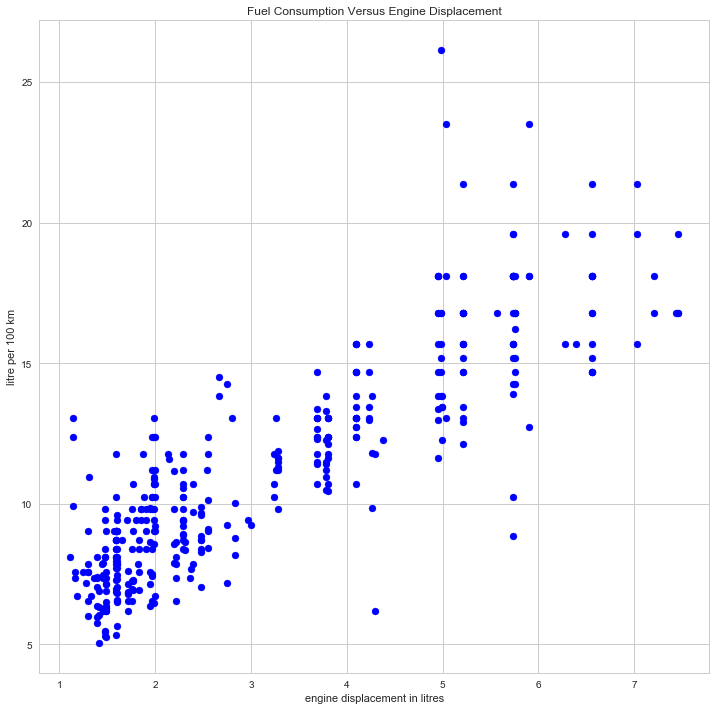

In [12]:
plt.figure(figsize=(12, 12))
sns.set(style='whitegrid')
plt.scatter(X, Y, c='b')
plt.xlabel('engine displacement in litres')
plt.ylabel('litre per 100 km')
plt.title('Fuel Consumption Versus Engine Displacement')

Next, we want to show how linear regression can be formulated as a <em style="color:blue;">minimization problem</em> and how this minimization problem can be solved using TensorFlow.

In [13]:
import tensorflow as tf

This example differs from our first example as this time the function that we want to minimize depends on a 
set of <font style="color:blue;">training data</font>.  Therefore, we have to define 
<font style="color:blue;">placeholders</font> to insert our data into TensorFlow. We define a `placeholder` 
for the independent variable `displacement` and a `placeholder` for the dependent variable `lph`.  

As we do not want to hardwire the number of examples,  we set the `shape` of these placeholders to `None`.

In [14]:
X_ph = tf.placeholder(tf.float32, shape=(None,))
Y_ph = tf.placeholder(tf.float32, shape=(None,))

We have a linear model to predict the fuel consumption from the displacement.  This linear model is as follows:
$$ Y = \vartheta \cdot X $$
Here $X$ is the engine displacement, while $Y$ is the fuel consumption.  Note that this linear model does not 
include a bias.  The reason is that this bias should be $0$, and hence we do not include it.  

A first guess for $\vartheta$ would be the average fuel consumption divided by the average engine displacement: 

In [15]:
theta_initial = np.mean(Y) / np.mean(X)
theta_initial

3.530787587283287

$\vartheta$ is the variable that we want to find.  Hence we declare it as a TensorFlow `Variable`.

In [16]:
ϑ = tf.Variable(theta_initial, dtype=tf.float32)
Y_predicted = ϑ * X_ph

The <font style="color:blue;">loss function</font> is defined as the sum of the squares of the errors. 
In order to normalize the loss, we divide it by the number of training examples $m$.
$$ \texttt{loss} := \frac{1}{m} \cdot \sum\limits_{i=1}^m \bigl(\vartheta \cdot x_i - y_i\bigr) $$
Here $x_i$ is the engine displacement of the $i$-th training example, while $y_i$ is the fuel consumption
of this training example.  Our goal is to determine the value of $\vartheta$ that mimimizes this loss function.

The function <a href="https://www.tensorflow.org/api_docs/python/tf/math/square"><tt>square</tt></a>
takes an array and squares it elementwise.  The function
<a href="https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum"><tt>reduce_sum</tt></a>
computes the sum of all elements of an array.

In [17]:
loss = tf.reduce_sum(tf.square(Y_predicted - Y_ph)) / m
loss

<tf.Tensor 'truediv:0' shape=() dtype=float32>

We will use <font style="color:blue;">gradient descent</font> to minimize our 
<font style="color:blue;">loss function</font>.  After some experimentation, I have chosen a 
<font style="color:blue;">learning rate</font> $\alpha$ of $0.03$:

In [18]:
α         = 0.03
train     = tf.train.GradientDescentOptimizer(α)
optimizer = train.minimize(loss)

Finally, we can start a TensorFlow session and run our optimizer for 11 steps of gradient descent.
Observe how we have used the <font style="color:blue;">dictionary</font> `data_dict` to feed the
training data into our optimizer.

In [19]:
init = tf.global_variables_initializer()
with tf.Session() as s:
    s.run(init)
    data_dict = {X_ph: X, Y_ph: Y}
    for k in range(9):
        s.run(optimizer, data_dict)            # one step of gradient descent
        theta, l = s.run([ϑ, loss], data_dict) # evaluate the variable ϑ and the loss function
        print('%2d: ϑ = %f, loss = %f' % (k, theta, l))

 0: ϑ = 3.257284, loss = 9.388667
 1: ϑ = 3.198470, loss = 9.318620
 2: ϑ = 3.185823, loss = 9.315380
 3: ϑ = 3.183103, loss = 9.315230
 4: ϑ = 3.182518, loss = 9.315223
 5: ϑ = 3.182393, loss = 9.315222
 6: ϑ = 3.182366, loss = 9.315223
 7: ϑ = 3.182360, loss = 9.315223
 8: ϑ = 3.182359, loss = 9.315223


We can conclude: For a car from the early eighties that has an engine displacement of $d$ litres, the fuel consumption is about $3.18 \cdot d$ litres per 100 kilometres.

If we compare this notebook to the notebook 
<a href="https://github.com/karlstroetmann/Artificial-Intelligence/blob/master/Python/Simple-Linear-Regression.ipynb">Simple-Linear-Regression.ipynb</a> that we had developed at the beginning of this lecture
we notice the following:  
  - In the notebook `Simple-Linear-Regression.ipynb` we had to derive a formula to compute the minimum
    of the loss function.
  - In the current notebook, we just had to define the <font style="color:blue;">gradient descent</font>.  
    Everything else is dealt with by TensorFlow.

Text(0.5,1,'Fuel Consumption versus Engine Displacement')

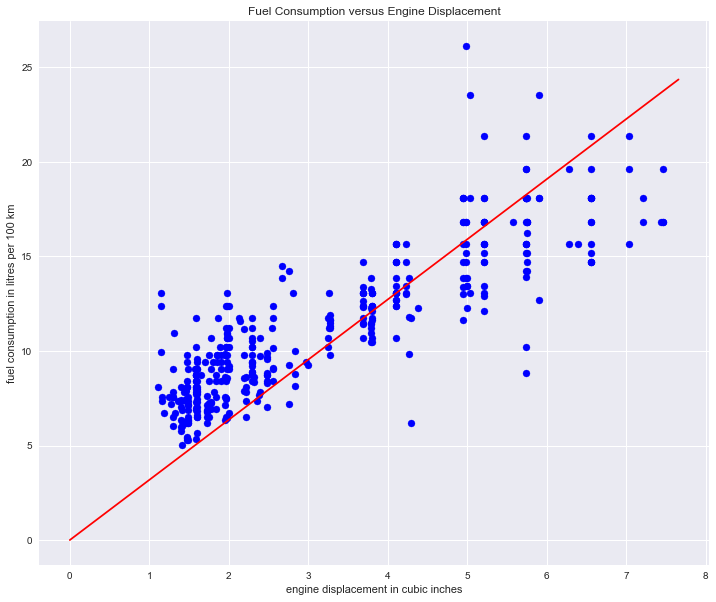

In [20]:
xMax = max(X) + 0.2
plt.figure(figsize=(12, 10))
sns.set(style='darkgrid')
plt.scatter(X, Y, c='b')
plt.plot([0, xMax], [0, theta * xMax], c='r')
plt.xlabel('engine displacement in cubic inches')
plt.ylabel('fuel consumption in litres per 100 km')
plt.title('Fuel Consumption versus Engine Displacement')